In [ ]:
pip install -U scikit-fuzzy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control
from tensorflow import keras
import cv2


### **INPUT AND WEIGHTS ADJUST**

**Here you can set an inputs in the given intervals**

TREMOR INPUTS

In [ ]:
# 0 - 1.5
DURING_WRITING_INPUT=1
# 0 - 5.7
DURING_RESTING_INPUT=5.4
# spiral draw input photo
SPIRAL_TEST_INPUT_IMAGE = 'gdrive/MyDrive/archive(1)/spiral/own_test/KL_1.JPG'

COGNITIVE INPUTS

In [ ]:
# 0 - 5
SPEECH_INPUT=2
# 0 - 4
SLOWNESS_INPUT=3

NON-MOTOR INPUTS

In [ ]:
# 0 - 69
SLEEP_DISORDER_INPUT=60
# 0 - 27
DEPRESSION_INPUT=10

# **MEMBERSHIP FUNCTION OF TREMOR SYMPTOMS**

### **CLASSIFICATION OF THE SPIRAL DRAW**
I trained a neural network with spiral draw by people who have parkinson disease and who are healthy. The whole training can be found in *parkinsonClassifier.ipynb* jupyter notebook. 
Here I just load the images and the trained model (the default input photo is mine, so I labeled it with healthy label).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(368, 368, 3)
[[1. 0.]]


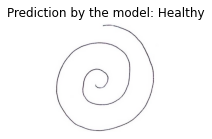

In [ ]:
model = keras.models.load_model("gdrive/MyDrive/Colab Notebooks/parkinson_disease_detection_epoch70.h5")
labels = ['Healthy', 'Parkinson']
image_healthy = cv2.imread(SPIRAL_TEST_INPUT_IMAGE)
print(image_healthy.shape)
image_healthy1=image_healthy
image_healthy = cv2.resize(image_healthy, (128, 128))
image_healthy = cv2.cvtColor(image_healthy, cv2.COLOR_BGR2GRAY)
image_healthy = np.array(image_healthy)
image_healthy = np.expand_dims(image_healthy, axis=0)
image_healthy = np.expand_dims(image_healthy, axis=-1)

prediction = model.predict(image_healthy)

print(prediction)

figure = plt.figure(figsize=(2, 2))
plt.imshow(image_healthy1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(prediction[0], axis=0)]}')
plt.show()

SPIRAL_TEST_INPUT = prediction[0][0]


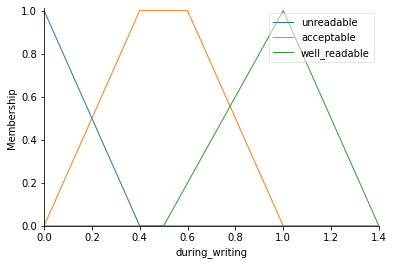

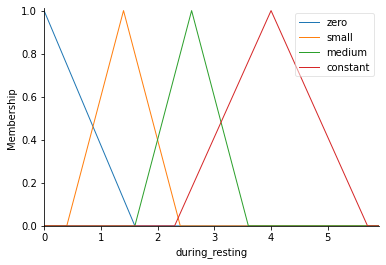

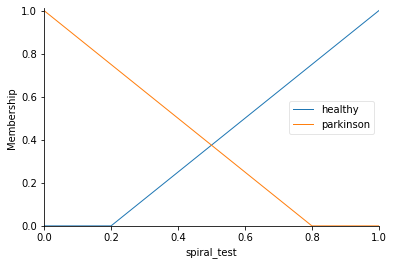

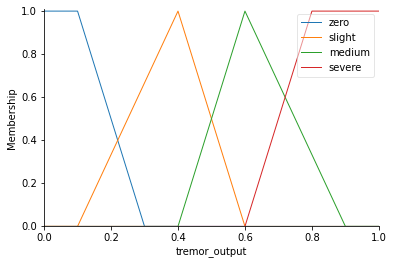

In [ ]:
during_writing_interval = np.arange(0,1.5,0.1)
during_resting_interval = np.arange(0,6,0.1)
spiral_test_interval = np.arange(0,1.1, 0.1)
output_interval = np.arange(0,1.1,0.1)

during_writing=control.Antecedent(during_writing_interval, 'during_writing')
during_resting=control.Antecedent(during_resting_interval, 'during_resting')
spiral_test=control.Antecedent(spiral_test_interval, 'spiral_test')
output=control.Antecedent(output_interval, 'output')

tremor = control.Consequent(output_interval, 'tremor_output')

during_writing['unreadable']= fuzz.trimf(during_writing.universe, [0,0,0.4])
during_writing['acceptable']= fuzz.trapmf(during_writing.universe, [0,0.4,0.6,1.0])
during_writing['well_readable']= fuzz.trimf(during_writing.universe, [0.5,1,1.4])

during_resting['zero']= fuzz.trimf(during_resting.universe, [0,0,1.6])
during_resting['small']= fuzz.trimf(during_resting.universe, [0.4,1.4,2.4])
during_resting['medium']= fuzz.trimf(during_resting.universe, [1.6,2.6,3.6])
during_resting['constant']= fuzz.trimf(during_resting.universe, [2.3,4,5.7])

spiral_test['healthy']= fuzz.trimf(spiral_test.universe, [0.2,1,1])
spiral_test['parkinson']= fuzz.trimf(spiral_test.universe, [0,0,0.8])

tremor['zero']= fuzz.trapmf(output.universe, [0,0, 0.1, 0.3])
tremor['slight']= fuzz.trimf(output.universe, [0.1,0.4,0.6])
tremor['medium']= fuzz.trimf(output.universe, [0.4,0.6, 0.9])
tremor['severe']= fuzz.trapmf(output.universe, [0.6,0.8,1, 1])

during_writing.view()
during_resting.view()
spiral_test.view()

tremor.view()

## **RULES OF TREMOR SYMPTOMS**

In [ ]:
r1 = control.Rule(during_writing['well_readable']&during_resting['zero']
                  &spiral_test['healthy'],
                  tremor['zero'])
r2 = control.Rule(during_writing['well_readable']&during_resting['small']
                  &spiral_test['healthy'],
                  tremor['slight'])
r3 = control.Rule(during_writing['well_readable']&during_resting['medium']
                  &spiral_test['healthy'],
                  tremor['slight'])
r4 = control.Rule(during_writing['well_readable']&during_resting['constant']
                  &spiral_test['healthy'],
                  tremor['medium'])

r5 = control.Rule(during_writing['acceptable']&during_resting['zero']
                  &spiral_test['healthy'],
                  tremor['zero'])
r6 = control.Rule(during_writing['acceptable']&during_resting['small']
                  &spiral_test['healthy'],
                  tremor['zero'])
r7 = control.Rule(during_writing['acceptable']&during_resting['medium']
                  &spiral_test['healthy'],
                  tremor['medium'])
r8 = control.Rule(during_writing['acceptable']&during_resting['constant']
                  &spiral_test['healthy'],
                  tremor['severe'])

r9 = control.Rule(during_writing['unreadable']&during_resting['zero']
                  &spiral_test['healthy'],
                  tremor['slight'])
r10 = control.Rule(during_writing['unreadable']&during_resting['small']
                   &spiral_test['healthy'],
                   tremor['medium'])
r11 = control.Rule(during_writing['unreadable']&during_resting['medium']
                   &spiral_test['healthy'],
                   tremor['severe'])
r12 = control.Rule(during_writing['unreadable']&during_resting['constant']
                   &spiral_test['healthy'],
                   tremor['severe'])

r13 = control.Rule(during_writing['well_readable']&during_resting['zero']
                   &spiral_test['parkinson'],
                   tremor['slight'])
r14 = control.Rule(during_writing['well_readable']&during_resting['small']
                   &spiral_test['parkinson'],
                   tremor['medium'])
r15 = control.Rule(during_writing['well_readable']&during_resting['medium']
                   &spiral_test['parkinson'],
                   tremor['medium'])
r16 = control.Rule(during_writing['well_readable']&during_resting['constant']
                   &spiral_test['parkinson'],
                   tremor['severe'])

r17 = control.Rule(during_writing['acceptable']&during_resting['zero']
                   &spiral_test['parkinson'],
                   tremor['medium'])
r18 = control.Rule(during_writing['acceptable']&during_resting['small']
                   &spiral_test['parkinson'],
                   tremor['medium'])
r19 = control.Rule(during_writing['acceptable']&during_resting['medium']
                   &spiral_test['parkinson'],
                   tremor['medium'])
r20 = control.Rule(during_writing['acceptable']&during_resting['constant']
                   &spiral_test['parkinson'],
                   tremor['severe'])

r21 = control.Rule(during_writing['unreadable']&during_resting['zero']
                   &spiral_test['parkinson'],
                   tremor['medium'])
r22 = control.Rule(during_writing['unreadable']&during_resting['small']
                   &spiral_test['parkinson'],
                   tremor['severe'])
r23 = control.Rule(during_writing['unreadable']&during_resting['medium']
                   &spiral_test['parkinson'],
                   tremor['severe'])
r24 = control.Rule(during_writing['unreadable']&during_resting['constant']
                   &spiral_test['parkinson'],
                   tremor['severe'])

result = control.ControlSystem([r1,r2,r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13,r14,r15, r16, r17, r18, r19, r20, r21, r22, r23, r24])

In [ ]:
result = control.ControlSystemSimulation(result)

In [ ]:
# 0 - 1.6
result.input['during_writing']=DURING_WRITING_INPUT
# 0 - 5.4
result.input['during_resting']=DURING_RESTING_INPUT
# uploaded image
result.input['spiral_test']=SPIRAL_TEST_INPUT


In [ ]:
result.compute()
tremor_result=result.output
tremor_result

OrderedDict([('tremor_output', 0.6457305502846299)])

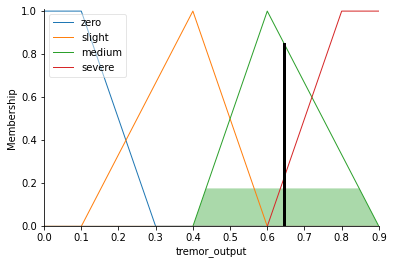

In [ ]:
tremor.view(sim=result)

# **MEMBERSHIP FUNCTION OF COGNITIVE SYMPTOMS**

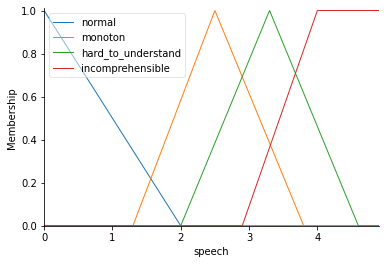

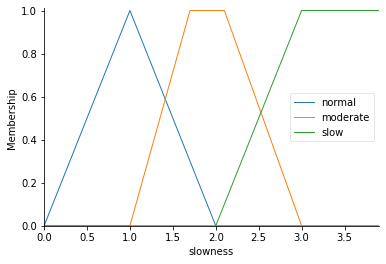

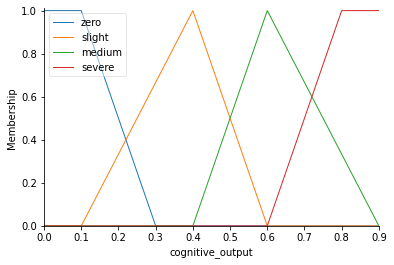

In [ ]:
speech_interval = np.arange(0,5,0.1)
slowness_interval = np.arange(0,4,0.1)
output_interval = np.arange(0,1,0.1)

speech=control.Antecedent(speech_interval, 'speech')
slowness=control.Antecedent(slowness_interval, 'slowness')
cognitive_output=control.Antecedent(output_interval, 'cognitive_output')

cognitive = control.Consequent(output_interval, 'cognitive_output')

# triangle membership function
speech['normal']= fuzz.trimf(speech.universe, [0, 0, 2])
speech['monoton']= fuzz.trimf(speech.universe, [1.3, 2.5, 3.8])
# trampf: trapez membership function
speech['hard_to_understand']= fuzz.trimf(speech.universe, [2, 3.3, 4.6])
speech['incomprehensible']= fuzz.trapmf(speech.universe, [2.9, 4.0, 5, 5])


# triangle membership function
slowness['normal']= fuzz.trimf(slowness.universe,[0,1,2])
slowness['moderate']= fuzz.trapmf(slowness.universe, [1,1.7,2.1,3])
slowness['slow']= fuzz.trapmf(slowness.universe, [2,3,4,4])



# triangle membership function
cognitive['zero']= fuzz.trapmf(cognitive_output.universe, [0,0, 0.1, 0.3])
cognitive['slight']= fuzz.trimf(cognitive_output.universe, [0.1,0.4,0.6])
cognitive['medium']= fuzz.trimf(cognitive_output.universe, [0.4,0.6, 0.9])
# trampf: trapez membership function
cognitive['severe']= fuzz.trapmf(cognitive_output.universe, [0.6,0.8,1, 1])

speech.view()
slowness.view()

cognitive.view()

## **RULES OF COGNITIVE SYMPTOMS**

In [ ]:
r1 = control.Rule(speech['normal']&slowness['normal'],
                  cognitive['zero'])
r2 = control.Rule(speech['normal']&slowness['moderate'],
                  cognitive['slight'])
r3 = control.Rule(speech['normal']&slowness['slow'],
                  cognitive['medium'])

r4 = control.Rule(speech['monoton']&slowness['normal'],
                  cognitive['zero'])
r5 = control.Rule(speech['monoton']&slowness['moderate'],
                  cognitive['slight'])
r6 = control.Rule(speech['monoton']&slowness['slow'],
                  cognitive['severe'])

r7 = control.Rule(speech['hard_to_understand']&slowness['normal'],
                  cognitive['slight'])
r8 = control.Rule(speech['hard_to_understand']&slowness['moderate'],
                  cognitive['medium'])
r9 = control.Rule(speech['hard_to_understand']&slowness['slow'],
                  cognitive['severe'])

r10 = control.Rule(speech['incomprehensible']&slowness['normal'],
                   cognitive['medium'])
r11 = control.Rule(speech['incomprehensible']&slowness['moderate'],
                   cognitive['severe'])
r12 = control.Rule(speech['incomprehensible']&slowness['slow'],
                   cognitive['severe'])

result = control.ControlSystem([r1,r2,r3, r4, r5, r6, r7,
                                r8, r9, r10, r11, r12])

In [ ]:
result = control.ControlSystemSimulation(result)

In [ ]:
#0 - 5
result.input['speech']=SPEECH_INPUT
#0 - 4
result.input['slowness']=SLOWNESS_INPUT

In [ ]:
result.compute()
cognitive_result=result.output
cognitive_result


OrderedDict([('cognitive_output', 0.7768199233716475)])

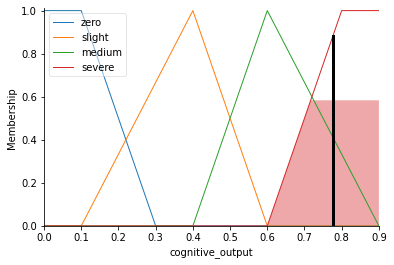

In [ ]:
cognitive.view(sim=result)

# **MEMBERSHIP FUNCTION OF NON-MOTOR SYMPTOMS**

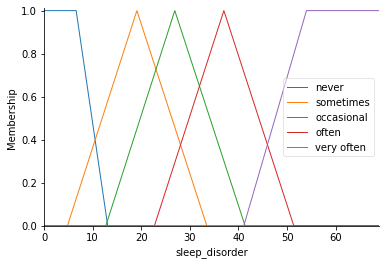

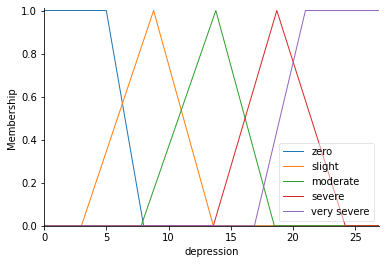

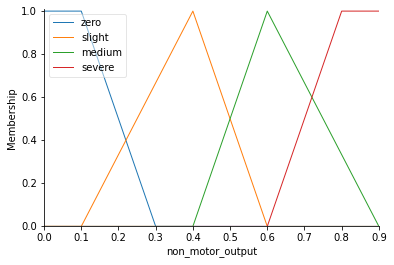

In [ ]:
#PDSS_alvaszavar: 0 - 69
sleep_disorder_interval = np.arange(0,69,0.1)
#HDRS depression: 0 - 27
depression_interval = np.arange(0,27,0.1)
output_interval = np.arange(0,1,0.1)

sleep_disorder=control.Antecedent(sleep_disorder_interval, 'sleep_disorder')
depression=control.Antecedent(depression_interval, 'depression')
non_motor_output=control.Antecedent(output_interval, 'non_motor_output')

non_motor = control.Consequent(output_interval, 'non_motor_output')

sleep_disorder['never']= fuzz.trapmf(sleep_disorder.universe,
                                     [0, 0, 6.6, 13.1])
sleep_disorder['sometimes']= fuzz.trimf(sleep_disorder.universe,
                                        [4.8, 19.1, 33.5])
sleep_disorder['occasional']= fuzz.trimf(sleep_disorder.universe,
                                         [12.7, 26.9, 41.37])
sleep_disorder['often']= fuzz.trimf(sleep_disorder.universe,
                                    [22.7, 37, 51.4])
sleep_disorder['very often']= fuzz.trapmf(sleep_disorder.universe,
                                          [41.1, 54.0, 69, 69])


depression['zero']= fuzz.trapmf(depression.universe,
                                [0, 0, 5, 8])
depression['slight']= fuzz.trimf(depression.universe,
                                 [3.0, 8.8, 13.6])
depression['moderate']= fuzz.trimf(depression.universe,
                                   [7.8, 13.8, 18.5])
depression['severe']= fuzz.trimf(depression.universe,
                                 [13.6, 18.7, 24.2])
depression['very severe']= fuzz.trapmf(depression.universe,
                                       [16.9, 21, 27, 27])



# triangle membership function
non_motor['zero']= fuzz.trapmf(non_motor_output.universe, [0,0, 0.1, 0.3])
non_motor['slight']= fuzz.trimf(non_motor_output.universe, [0.1,0.4,0.6])
non_motor['medium']= fuzz.trimf(non_motor_output.universe, [0.4,0.6, 0.9])
# trampf: trapez membership function
non_motor['severe']= fuzz.trapmf(non_motor_output.universe, [0.6,0.8,1, 1])

sleep_disorder.view()
depression.view()

non_motor.view()

## **RULES OF NON-MOTOR SYMPTOMS**

In [ ]:
r1 = control.Rule(sleep_disorder['never']&depression['zero'], non_motor['zero'])
r2 = control.Rule(sleep_disorder['never']&depression['slight'], non_motor['zero'])
r3 = control.Rule(sleep_disorder['never']&depression['moderate'], non_motor['slight'])
r4 = control.Rule(sleep_disorder['never']&depression['severe'], non_motor['slight'])
r5 = control.Rule(sleep_disorder['never']&depression['very severe'], non_motor['medium'])


r6 = control.Rule(sleep_disorder['sometimes']&depression['zero'], non_motor['zero'])
r7 = control.Rule(sleep_disorder['sometimes']&depression['slight'], non_motor['slight'])
r8 = control.Rule(sleep_disorder['sometimes']&depression['moderate'], non_motor['slight'])
r9 = control.Rule(sleep_disorder['sometimes']&depression['severe'], non_motor['medium'])
r10 = control.Rule(sleep_disorder['sometimes']&depression['very severe'], non_motor['medium'])

r11 = control.Rule(sleep_disorder['occasional']&depression['zero'], non_motor['zero'])
r12 = control.Rule(sleep_disorder['occasional']&depression['slight'], non_motor['slight'])
r13 = control.Rule(sleep_disorder['occasional']&depression['moderate'], non_motor['medium'])
r14 = control.Rule(sleep_disorder['occasional']&depression['severe'], non_motor['medium'])
r15 = control.Rule(sleep_disorder['occasional']&depression['very severe'], non_motor['medium'])

r16 = control.Rule(sleep_disorder['often']&depression['zero'], non_motor['zero'])
r17 = control.Rule(sleep_disorder['often']&depression['slight'], non_motor['slight'])
r18 = control.Rule(sleep_disorder['often']&depression['moderate'], non_motor['medium'])
r19 = control.Rule(sleep_disorder['often']&depression['severe'], non_motor['medium'])
r20 = control.Rule(sleep_disorder['often']&depression['very severe'], non_motor['severe'])

r21 = control.Rule(sleep_disorder['very often']&depression['zero'], non_motor['zero'])
r22 = control.Rule(sleep_disorder['very often']&depression['slight'], non_motor['medium'])
r23 = control.Rule(sleep_disorder['very often']&depression['moderate'], non_motor['medium'])
r24 = control.Rule(sleep_disorder['very often']&depression['severe'], non_motor['medium'])
r25 = control.Rule(sleep_disorder['very often']&depression['very severe'], non_motor['severe'])



result = control.ControlSystem([r1,r2,r3, r4, r5, r6, r7, r8, r9, r10, r11, r12,r13,r14,r15, r16, r17, r18, r19, r20, r21, r22, r23, r24, r25])

In [ ]:
result = control.ControlSystemSimulation(result)

In [ ]:
#0 - 69
result.input['sleep_disorder']=SLEEP_DISORDER_INPUT
#0 - 27
result.input['depression']=DEPRESSION_INPUT

In [ ]:
result.compute()
non_motor_result=result.output

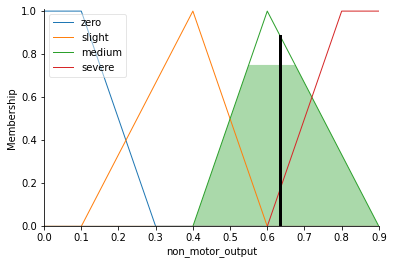

In [ ]:
non_motor.view(sim=result)

# **MEMBERSHIP FUNCTION OF MOTOR SYMPTOMS**

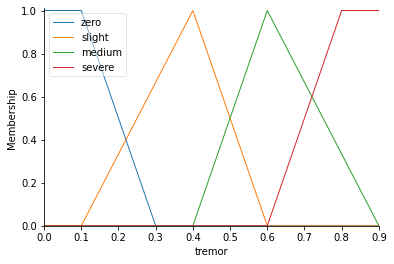

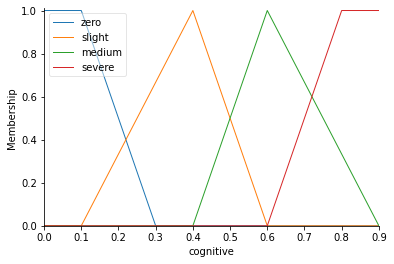

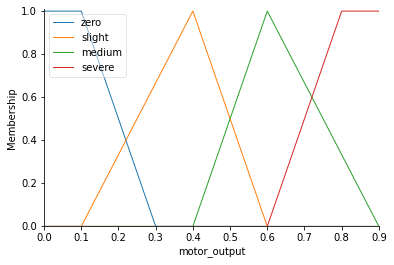

In [ ]:
#Tremor: 0 - 1
tremor_interval = np.arange(0,1,0.1)
#HDRS cognitive: 0 - 1
cognitive_interval = np.arange(0,1,0.1)
output_interval = np.arange(0,1,0.1)

tremor=control.Antecedent(tremor_interval, 'tremor')
cognitive=control.Antecedent(cognitive_interval, 'cognitive')
motor_output=control.Antecedent(output_interval, 'motor_output')

motor = control.Consequent(output_interval, 'motor_output')
tremor['zero']= fuzz.trapmf(output.universe, [0,0, 0.1, 0.3])
tremor['slight']= fuzz.trimf(output.universe, [0.1,0.4,0.6])
tremor['medium']= fuzz.trimf(output.universe, [0.4,0.6, 0.9])
# trampf: trapez membership function
tremor['severe']= fuzz.trapmf(output.universe, [0.6,0.8,1, 1])


cognitive['zero']= fuzz.trapmf(cognitive_output.universe, [0,0, 0.1, 0.3])
cognitive['slight']= fuzz.trimf(cognitive_output.universe, [0.1,0.4,0.6])
cognitive['medium']= fuzz.trimf(cognitive_output.universe, [0.4,0.6, 0.9])
cognitive['severe']= fuzz.trapmf(cognitive_output.universe, [0.6,0.8,1, 1])



# triangle membership function
motor['zero']= fuzz.trapmf(motor_output.universe, [0,0, 0.1, 0.3])
motor['slight']= fuzz.trimf(motor_output.universe, [0.1,0.4,0.6])
motor['medium']= fuzz.trimf(motor_output.universe, [0.4,0.6, 0.9])
# trampf: trapez membership function
motor['severe']= fuzz.trapmf(motor_output.universe, [0.6,0.8,1, 1])

tremor.view()
cognitive.view()


motor.view()

## **RULES OF MOTOR SYMPTOMS**

> Indented block



In [ ]:
r1 = control.Rule(tremor['zero']&cognitive['zero'], motor['zero'])
r2 = control.Rule(tremor['zero']&cognitive['slight'], motor['zero'])
r3 = control.Rule(tremor['zero']&cognitive['medium'], motor['slight'])
r4 = control.Rule(tremor['zero']&cognitive['severe'], motor['slight'])



r5 = control.Rule(tremor['slight']&cognitive['zero'], motor['zero'])
r6 = control.Rule(tremor['slight']&cognitive['slight'], motor['slight'])
r7 = control.Rule(tremor['slight']&cognitive['medium'], motor['slight'])
r8 = control.Rule(tremor['slight']&cognitive['severe'], motor['medium'])


r9 = control.Rule(tremor['medium']&cognitive['zero'], motor['slight'])
r10 = control.Rule(tremor['medium']&cognitive['slight'], motor['slight'])
r11 = control.Rule(tremor['medium']&cognitive['medium'], motor['medium'])
r12 = control.Rule(tremor['medium']&cognitive['severe'], motor['severe'])


r13 = control.Rule(tremor['severe']&cognitive['zero'], motor['medium'])
r14 = control.Rule(tremor['severe']&cognitive['slight'], motor['medium'])
r15 = control.Rule(tremor['severe']&cognitive['medium'], motor['severe'])
r16 = control.Rule(tremor['severe']&cognitive['severe'], motor['severe'])






result = control.ControlSystem([r1,r2,r3, r4, r5, r6, r7, r8, r9, r10, r11, r12,r13,r14,r15, r16])

In [ ]:
result = control.ControlSystemSimulation(result)

In [ ]:
#0 - 1
result.input['tremor']=tremor_result['tremor_output']
#0 - 1
result.input['cognitive']=cognitive_result['cognitive_output']

In [ ]:
result.compute()
motor_result = result.output
motor_result['motor_output']

0.7098487207040641

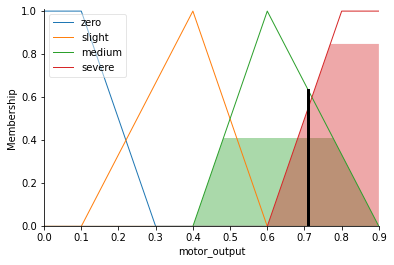

In [ ]:
motor.view(sim=result)

# **MEMBERSHIP FUNCTION OF LEVEL OF DISEASE SYMPTOMS**

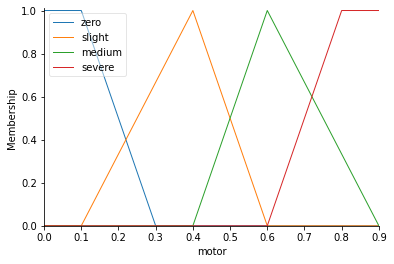

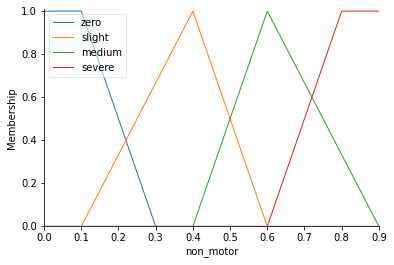

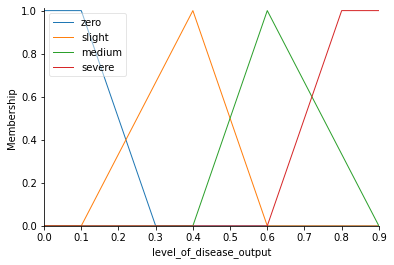

In [ ]:
#motor: 0 - 1
tremor_interval = np.arange(0,1,0.1)
#HDRS non_motor: 0 - 1
non_motor_interval = np.arange(0,1,0.1)
output_interval = np.arange(0,1,0.1)

motor=control.Antecedent(tremor_interval, 'motor')
non_motor=control.Antecedent(non_motor_interval, 'non_motor')
level_of_disease_output=control.Antecedent(output_interval,
                                           'level_of_disease_output')

level_of_disease = control.Consequent(output_interval,
                                      'level_of_disease_output')

motor['zero']= fuzz.trapmf(motor_output.universe, [0,0, 0.1, 0.3])
motor['slight']= fuzz.trimf(motor_output.universe, [0.1,0.4,0.6])
motor['medium']= fuzz.trimf(motor_output.universe, [0.4,0.6, 0.9])
motor['severe']= fuzz.trapmf(motor_output.universe, [0.6,0.8,1, 1])

non_motor['zero']= fuzz.trapmf(non_motor_output.universe, [0,0, 0.1, 0.3])
non_motor['slight']= fuzz.trimf(non_motor_output.universe, [0.1,0.4,0.6])
non_motor['medium']= fuzz.trimf(non_motor_output.universe, [0.4,0.6, 0.9])
non_motor['severe']= fuzz.trapmf(non_motor_output.universe, [0.6,0.8,1, 1])

level_of_disease['zero']= fuzz.trapmf(level_of_disease_output.universe,
                                      [0,0, 0.1, 0.3])
level_of_disease['slight']= fuzz.trimf(level_of_disease_output.universe,
                                       [0.1,0.4,0.6])
level_of_disease['medium']= fuzz.trimf(level_of_disease_output.universe,
                                       [0.4,0.6, 0.9])
level_of_disease['severe']= fuzz.trapmf(level_of_disease_output.universe,
                                        [0.6,0.8,1, 1])

motor.view()
non_motor.view()
level_of_disease.view()

## **RULES OF LEVEL OF DISEASE SYMPTOMS**

> Indented block



In [ ]:
r1 = control.Rule(motor['zero']&non_motor['zero'],
                  level_of_disease['zero'])
r2 = control.Rule(motor['zero']&non_motor['slight'],
                  level_of_disease['zero'])
r3 = control.Rule(motor['zero']&non_motor['medium'],
                  level_of_disease['slight'])
r4 = control.Rule(motor['zero']&non_motor['severe'],
                  level_of_disease['slight'])

r5 = control.Rule(motor['slight']&non_motor['zero'],
                  level_of_disease['zero'])
r6 = control.Rule(motor['slight']&non_motor['slight'],
                  level_of_disease['slight'])
r7 = control.Rule(motor['slight']&non_motor['medium'],
                  level_of_disease['slight'])
r8 = control.Rule(motor['slight']&non_motor['severe'],
                  level_of_disease['medium'])

r9 = control.Rule(motor['medium']&non_motor['zero'],
                  level_of_disease['slight'])
r10 = control.Rule(motor['medium']&non_motor['slight'],
                   level_of_disease['slight'])
r11 = control.Rule(motor['medium']&non_motor['medium'],
                   level_of_disease['medium'])
r12 = control.Rule(motor['medium']&non_motor['severe'],
                   level_of_disease['severe'])

r13 = control.Rule(motor['severe']&non_motor['zero'],
                   level_of_disease['medium'])
r14 = control.Rule(motor['severe']&non_motor['slight'],
                   level_of_disease['medium'])
r15 = control.Rule(motor['severe']&non_motor['medium'],
                   level_of_disease['severe'])
r16 = control.Rule(motor['severe']&non_motor['severe'],
                   level_of_disease['severe'])

result = control.ControlSystem([r1,r2,r3, r4, r5, r6, r7, r8, r9, r10, r11, r12,r13,r14,r15, r16])

In [ ]:
result = control.ControlSystemSimulation(result)

In [ ]:
#0 - 1
result.input['motor']=motor_result['motor_output']
#0 - 1
result.input['non_motor']=non_motor_result['non_motor_output']

In [ ]:
result.compute()
level_of_disease_result = result.output
level_of_disease_result['level_of_disease_output']

0.6734311307957486

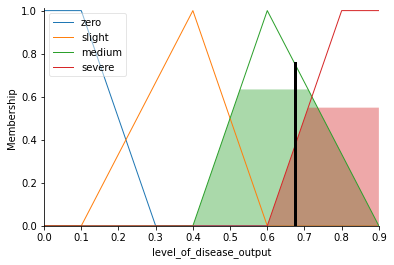

In [ ]:
level_of_disease.view(sim=result)

**Above we can see the result of the fuzzy interference system, the level of the parkinson disease.**




In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Fuzzy.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Fuzzy.ipynb to pdf
[NbConvertApp] Support files will be in Fuzzy_files/
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] Making directory ./Fuzzy_files
[NbConvertApp] M

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'